In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

x, y = make_moons(n_samples=500, noise=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 硬投票
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

votingz_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='hard'
)

In [3]:
votingz_clf.fit(x, y)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, votingz_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [5]:
# 软投票
# 如果所有分类器都能够估算出类别的概率（即有predict_proba（） 方法） ， 
# 那么你可以将概率在所有单个分类器上平均， 然后让Scikit-Learn给出平均概率最高的类别作为预测
# 通常来说， 它比硬投票法的表现更优， 因为它给予那些高度自信的投票更高的权重。 
# 而所有你需要做的就是用voting="soft"代替voting="hard"， 并确保所有分类器都可以估算出概率
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# Bagging ensembles

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500, #分类器数量
    max_samples=100, #每个评估器取的实例数
    bootstrap=False, #是否样本放回
    n_jobs=-1, #-1调用所有内核
    random_state=42
)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.912

In [26]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train)

y_pred_tree = tree_clf.predict(x_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [27]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

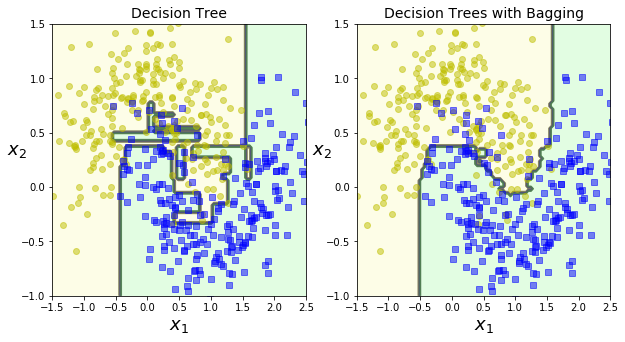

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(121)
plot_decision_boundary(tree_clf, x, y)
plt.title("Decision Tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, x, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.show()

**外包评估 Out-of-Bag evaluation**


In [44]:
x_train.shape

(375, 2)

In [42]:
# bootstrap=True取样后放回样本，对于每个预测器而言，

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True, #是否样本放回
    n_jobs=-1, #-1调用所有内核
    random_state=40,
    oob_score=True
)
bag_clf.fit(x_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [43]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.912

In [48]:
# 每个训练实例的包外决策函数也可以通过变量oob_decision_function_获得。 
# 本例中（基础预测器具备predict_proba（） 方法） ， 决策函数返回的是每个实例的类别概率。
bag_clf.oob_decision_function_
bag_clf.oob_decision_function_.shape,

((375, 2),)

**Random Patches和随机子空间**

*BaggingClassifier也支持对特征进行抽样， 这通过两个超参数控制： max_features和bootstrap_features。*

*它们的工作方式跟max_samples和bootstrap相同， 只是抽样对象不再是实例， 而是特征。*

*因此， 每个预测器将用输入特征的随机子集进行训练。这对于处理高维输入（例如图像） 特别有用。 
对训练实例和特征都进行抽样， 被称为Random Patches方法。*

*而保留所有训练实例（即bootstrap=False并且max_samples=1.0） 但是对特征进行抽样（即bootstrap_features=True并且/或max_features<1.0） ， 这被称为随机子空间法。 
对特征抽样给预测器带来更大的多样性， 所以以略高一点的偏差换取了更低的方差。*

**随机森林**

In [49]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

In [50]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1, 
                                 random_state=42)
rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_test)

In [53]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

# Feature importance

In [54]:
# 鸢尾花特征重要性
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()

In [55]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])

for name, score in zip(iris['feature_names'],rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08474115713922396
sepal width (cm) 0.022322323520711954
petal length (cm) 0.44138772456184133
petal width (cm) 0.4515487947782224


In [56]:
# 数字像素位重要性
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original',data_home='datasets')
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist['data'],mnist['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [57]:
import matplotlib.pyplot as plt
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.hot,
               interpolation="nearest")
    plt.axis("off")

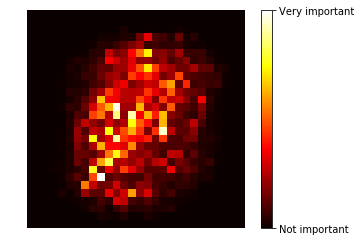

In [58]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

# AdaBoost

In [59]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

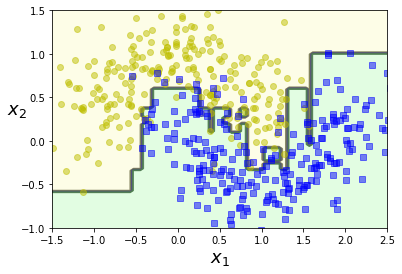

In [62]:
import numpy as np
plot_decision_boundary(ada_clf, x, y)

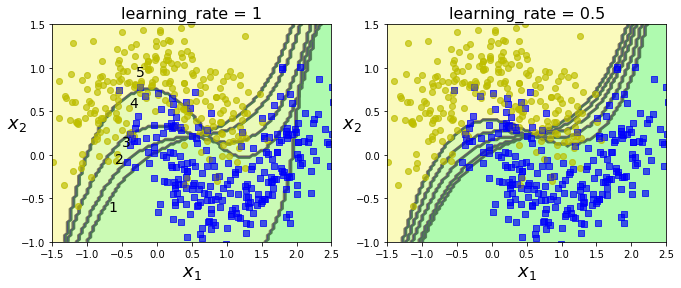

In [63]:
from sklearn.svm import SVC

m = len(x_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(x_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(x_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, x, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

# Gradient Boosting

In [64]:
np.random.seed(42)

X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [65]:
# 实现原理

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [66]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [67]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [68]:
X_new = np.array([[0.8]])

In [69]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

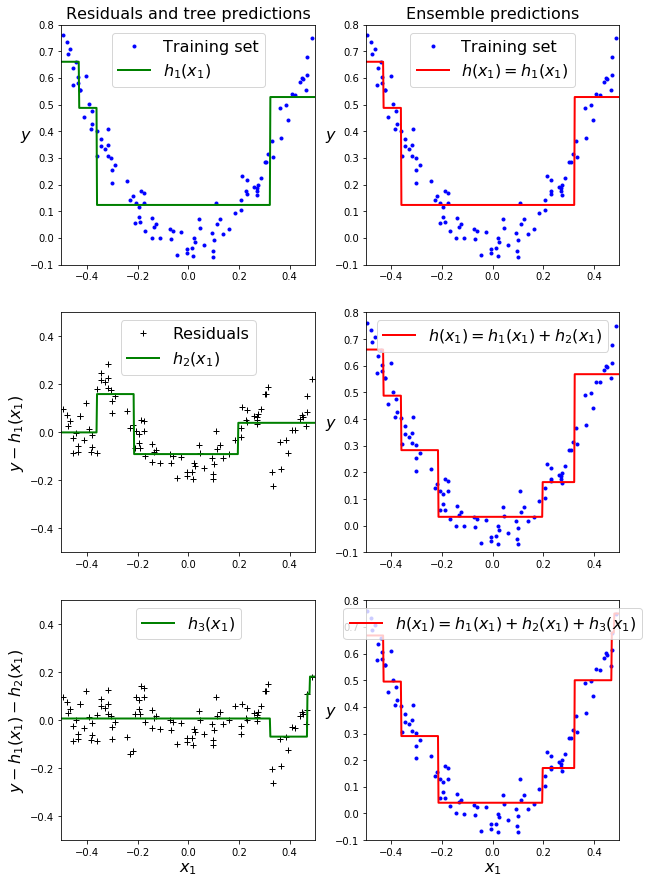

In [70]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(10,15))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

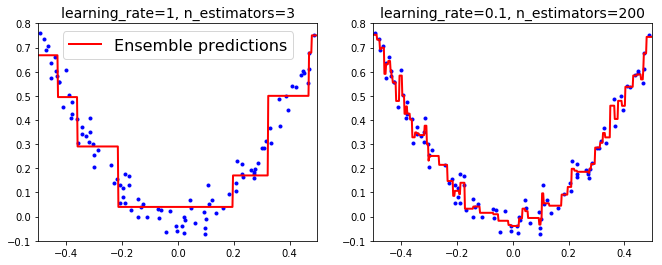

In [73]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

# Gradient Boosting with Early stopping

In [74]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) #数组最小值所在位置

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [75]:
min_error = np.min(errors)
min_error

0.002712853325235463

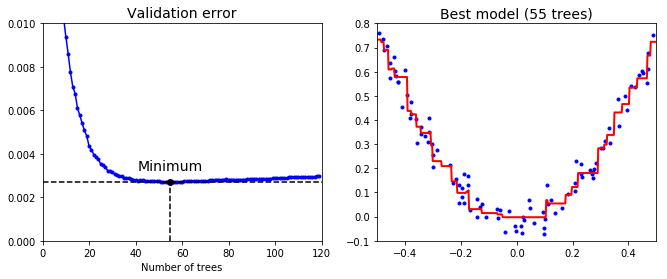

In [76]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

In [77]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
    if error_going_up == 5:
        break # early stopping

In [78]:
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

61
Minimum validation MSE: 0.002712853325235463


**1.如果你已经在完全相同的训练集上训练了五个不同的模型， 并且它们都达到了95%的准确率， 是否还有机会通过结合这些模型来获得更好的结果？ 如果可以， 该怎么做？ 如果不行， 为什么？**

1.如果你已经训练了五个不同的模型，并且都达到了95％的精度，你可以尝试将它们组合成一个投票集成，这通常会带来更好的结果。 
如果模型之间非常不同（例如，一个SVM分类器，一个决策树分类器，以及一个Logistic回归分类器等），则效果更优。 
如果它们是在不同的训练实例（这是bagging和pasting集成的关键点）上完成训练， 那就更好了， 但如果不是， 只要模型非常不同， 这个集成仍然有效。

**2.硬投票分类器和软投票分类器有什么区别？**

2.硬投票分类器只是统计每个分类器的投票， 然后挑选出得票最多的类别。 
软投票分类器计算出每个类别的平均估算概率， 然后选出概率最高的类别。
它比硬投票法的表现更优， 因为它给予那些高度自信的投票更高的权重。
但是它要求每个分类器都能够估算出类别概率才可以正常工作（例如， Scikit-Learn中的SVM分类器必须要设置probability=True） 。

**3.是否可以通过在多个服务器上并行来加速bagging集成的训练？pasting集成呢？ boosting集成呢？ 随机森林或stacking集成呢？**

3.对于bagging集成来说， 将其分布在多个服务器上能够有效加速训练过程， 因为集成中的每个预测器都是独立工作的。 
同理， 对于pasting集成和随机森林来说也是如此。 
但是， boosting集成的每个预测器都是基于其前序的结果， 因此训练过程必须是有序的， 将其分布在多个服务器上毫无意义。 
对于stacking集成来说， 某个指定层的预测器之间彼此独立， 因而可以在多台服务器上并行训练，
但是， 某一层的预测器只能在其前一层的预测器全部训练完成之后， 才能开始训练

**4.包外评估的好处是什么？**

4.包外评估可以对bagging集成中的每个预测器使用其未经训练的实例进行评估。 不需要额外的验证集， 就可以对集成实施相当公正的评估。 
所以， 如果训练使用的实例越多， 集成的性能可以略有提升。

**5.是什么让极端随机树比一般随机森林更加随机？ 这部分增加的随机性有什么用？ 极端随机树比一般随机森林快还是慢？**

5.随机森林在生长过程中， 每个节点的分裂仅考虑到了特征的一
个随机子集。 极限随机树也是如此， 它甚至走得更远： 常规决策树会
搜索出特征的最佳阈值， 极限随机树直接对每个特征使用随机阈值。
这种极限随机性就像是一种正则化的形式： 如果随机森林对训练数据
出现过度拟合， 那么极限随机树可能执行效果更好。 更甚的是， 极限
随机树不需要计算最佳阈值， 因此它训练起来比随机森林快得多。 但
是， 在做预测的时候， 相比随机森林它不快也不慢。

**6.如果你的AdaBoost集成对训练数据拟合不足， 你应该调整哪些超参数？ 怎么调整？**

6.如果你的AdaBoost集成对训练集拟合不足， 可以尝试提升估算器的数量或是降低基础估算器的正则化超参数。 
你也可以尝试略微提升学习率。


**7.如果你的梯度提升集成对训练集过度拟合， 你是应该提升还是降低学习率？**

7.如果你的梯度提升集成对训练集过度拟合， 你应该试着降低学习率， 也可以通过早停法来寻找合适的预测器数量（可能是因为预测器太多） 。
